In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
csv_path = "/home/jupyter/subset_1_1/export_data-seagen_subset_1_1-2020-12-23T08:55:47.943745Z/image_classification_1.csv"
df = pd.read_csv(csv_path, header=None)
df.rename(columns={0:"split", 1:"path", 2:"gt_label"}, inplace=True)
df.head()

,split,path,gt_label
0,TRAIN,gs://seagen-quantiphi/subset_1_1/export_data-s...,out_of_focus
1,TRAIN,gs://seagen-quantiphi/subset_1_1/export_data-s...,dim_positive
2,TRAIN,gs://seagen-quantiphi/subset_1_1/export_data-s...,HE
3,TRAIN,gs://seagen-quantiphi/subset_1_1/export_data-s...,dim_positive
4,TRAIN,gs://seagen-quantiphi/subset_1_1/export_data-s...,out_of_focus


In [3]:
print(df["gt_label"].value_counts())
print(df[df["gt_label"] == "out_of_focus"]["split"].value_counts())

out_of_focus       1461
no_tissue          1147
HE                  781
negative            769
strong_positive     735
dim_positive        442
necrotic            232
Name: gt_label, dtype: int64
TRAIN         1175
TEST           144
VALIDATION     142
Name: split, dtype: int64


## using Laplacian variance and Fourier transform as a measure to detect blurness of a image

In [9]:
def var_of_laplacian(img,kernel_size=1):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(gray, cv2.CV_64F, ksize = kernel_size).var()

def detect_blur_fft(image, size=60, thresh=10, vis=False):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # grab the dimensions of the image and use the dimensions to
    # derive the center (x, y)-coordinates
    (h, w) = image.shape
    (cX, cY) = (int(w / 2.0), int(h / 2.0))
    fft = np.fft.fft2(image)
    fftShift = np.fft.fftshift(fft)
    # check to see if we are visualizing our output
    if vis:
        # compute the magnitude spectrum of the transform
        magnitude = 20 * np.log(np.abs(fftShift))
        # display the original input image
        (fig, ax) = plt.subplots(1, 2, )
        ax[0].imshow(image, cmap="gray")
        ax[0].set_title("Input")
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        # display the magnitude image
        ax[1].imshow(magnitude, cmap="gray")
        ax[1].set_title("Magnitude Spectrum")
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        # show our plots
        plt.show()
    fftShift[cY - size:cY + size, cX - size:cX + size] = 0
    fftShift = np.fft.ifftshift(fftShift)
    recon = np.fft.ifft2(fftShift)
    
    magnitude = 20 * np.log(np.abs(recon))
    mean = np.mean(magnitude)
    # the image will be considered "blurry" if the mean value of the
    # magnitudes is less than the threshold value
    return mean


In [4]:
def get_inrange_mask(img, masked_img=False):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define color ranges in hsv

    lower_purple = np.array([70, 12, 10])
    upper_purple = np.array([178, 180, 255])

    lower_brown = np.array([14,25,10])
    upper_brown = np.array([56,127,255])
    
    # Get mask   
    mask_purple = cv2.inRange(hsv, lower_purple, upper_purple)
    purple_cover = mask_purple.sum()*100/(mask_purple.shape[0]*mask_purple.shape[1]*255)
    #print("Mask cover for purple/blue is {} percent".format(purple_cover))
    mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)
    brown_cover = mask_brown.sum()*100/(mask_brown.shape[0]*mask_brown.shape[1]*255)
    #print("Mask cover for brown is {} percent".format(brown_cover))
    
    mask = 255*(mask_purple + mask_brown)
    mask = mask.clip(0, 255).astype("uint8")
    
    # Bitwise-AND mask and original image
    if masked_img:
        res = cv2.bitwise_and(img,img, mask= mask)
        res_purple = cv2.bitwise_and(img,img, mask= mask_purple)
        res_brown = cv2.bitwise_and(img,img, mask= mask_brown)
        return res, res_purple, res_brown
    else:
        return purple_cover, brown_cover


def get_hsv_plots(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1], None, [256, 256], [0, 256, 0, 256])
    #print(hist)8
    fig, ax = plt.subplots(figsize=(18, 10))
    ax.imshow(hist, interpolation='nearest')
    plt.show()

In [5]:
from google.cloud import storage
# Initialise a client
storage_client = storage.Client()

seagen-quantiphi
to-be-annotated/strong_positive/img_027_08192_02048.png
(1024, 1024, 3)
Laplacian Variance: 914.4927651074814
FFT mean value: 38.58623884069489


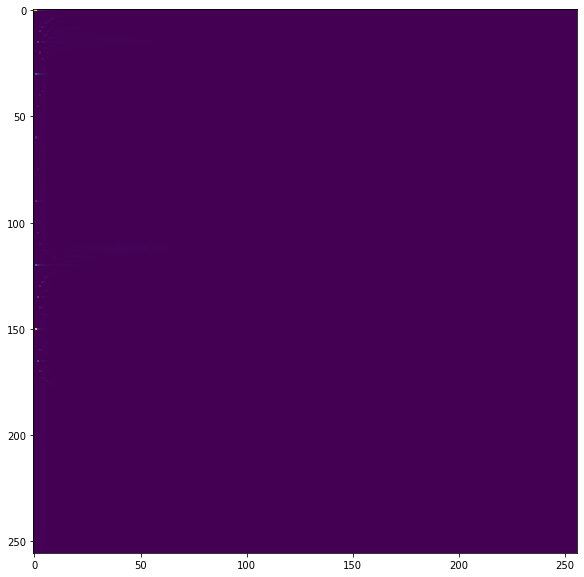

In [39]:
# Purple Blur
#test_img = "/home/jupyter/dataset/subset_1_1/export_data-seagen_subset_1_1-2020-12-23T08:55:47.943745Z/files/001efdac-ed5a-49ed-aaba-02ca2361886c.png"
# Brown Blur
#test_img = "/home/jupyter/dataset/subset_1_1/export_data-seagen_subset_1_1-2020-12-23T08:55:47.943745Z/files/00215f10-4285-474f-8566-250b2ab7c044.png"
# Blue Brown Focused
#test_img = "/home/jupyter/dataset/subset_1_1/export_data-seagen_subset_1_1-2020-12-23T08:55:47.943745Z/files/023c700c-51c1-48f9-ac15-97267533d914.png"

#test_img = "/home/jupyter/dataset/subset_1_1/export_data-seagen_subset_1_1-2020-12-23T08:55:47.943745Z/files/c286fb88-ce90-4769-9136-12aabda0b0e2.png"

gs_uri = "gs://seagen-quantiphi/to-be-annotated/strong_positive/img_027_08192_02048.png"
#gs_uri = "gs://seagen-quantiphi/to-be-annotated/out_of_focus/img_003_20480_02048.png"
#gs_uri = "gs://seagen-quantiphi/to-be-annotated/out_of_focus/img_007_19456_14336.png"
print(gs_uri.split("/")[2])
print("/".join(gs_uri.split("/")[3:]))
# Create a bucket object for our bucket
bucket = storage_client.get_bucket(gs_uri.split("/")[2])
# Create a blob object from the filepath
blob = bucket.blob("/".join(gs_uri.split("/")[3:]))
# Download the file to a destination
blob.download_to_filename("/home/jupyter/test_img.png")


im = cv2.imread("/home/jupyter/test_img.png")
print(im.shape)
new_im, new_im_purple, new_im_brown = get_inrange_mask(im, masked_img=True)
#get_hsv_plots(im)
print("Laplacian Variance: {}".format(var_of_laplacian(im)))
print("FFT mean value: {}".format(detect_blur_fft(im)))
#cv2.imwrite("/home/jupyter/test_img.png", im)
cv2.imwrite("/home/jupyter/test_mask.png", new_im)
cv2.imwrite("/home/jupyter/test_mask_blue-purple.png", new_im_purple)
cv2.imwrite("/home/jupyter/test_mask_brown.png", new_im_brown)
get_hsv_plots(im)

In [16]:
df["laplacian_var"] = 0.0
df["purple_cover"] = 0.0
df["brown_cover"] = 0.0
df["fft_blur"] = 0.0
for indx in df.index:
    img_path = "/home/jupyter/" + df["path"][indx][22:]
    #print(img_path)
    im = cv2.imread(img_path)
    #print(im)
    lap_var = var_of_laplacian(im)
    fft_blur = detect_blur_fft(im)
    purple_cover, brown_cover = get_inrange_mask(im)
    df["laplacian_var"][indx] = lap_var
    df["purple_cover"][indx] = purple_cover
    df["brown_cover"][indx] = brown_cover
    df["fft_blur"][indx] = fft_blur
    print(indx, end="\r")
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_l

In [17]:
df.to_csv("/home/jupyter/subset_1_1/df.csv", index=False)
df = pd.read_csv("/home/jupyter/subset_1_1/df.csv", delimiter=',')

Text(0, 0.5, 'Frequency')

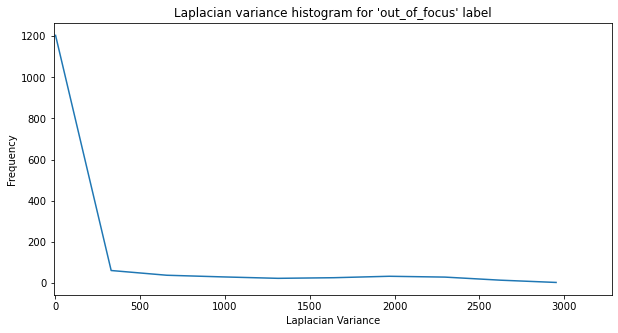

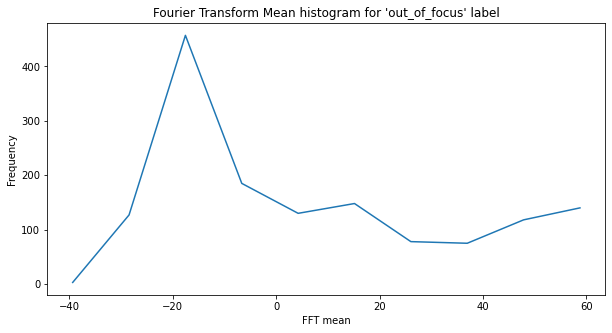

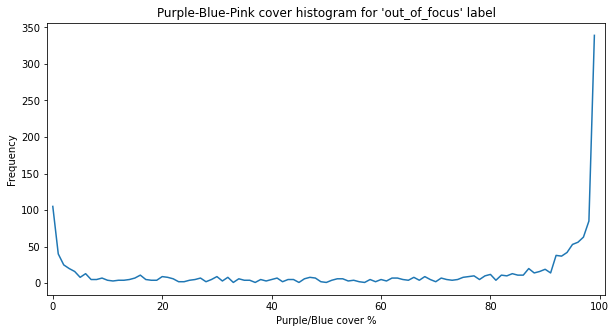

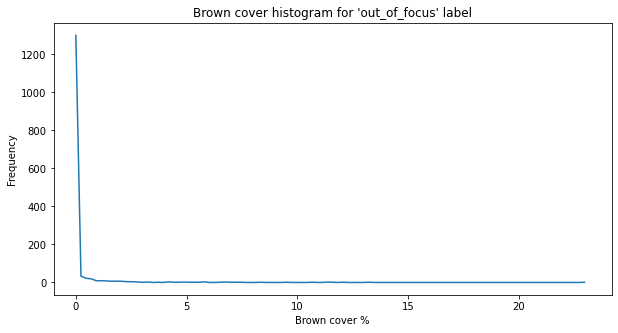

In [18]:
label = "out_of_focus"

arr_lap_var = df[df["gt_label"] == label]["laplacian_var"]
hist, bin_edges = np.histogram(arr_lap_var)
plt.figure(figsize=[10,5])
plt.title("Laplacian variance histogram for '{}' label".format(label))
plt.plot(bin_edges[:-1], hist)
plt.xlim(-10, max(bin_edges))
plt.xlabel("Laplacian Variance")
plt.ylabel("Frequency")
#plt.xlim(-10, 500)

arr_lap_var = df[df["gt_label"] == label]["fft_blur"]
hist, bin_edges = np.histogram(arr_lap_var)
plt.figure(figsize=[10,5])
plt.title("Fourier Transform Mean histogram for '{}' label".format(label))
plt.plot(bin_edges[:-1], hist)
#plt.xlim(-10, max(bin_edges))
plt.xlabel("FFT mean")
plt.ylabel("Frequency")


arr = df[df["gt_label"] == label]["purple_cover"]
hist, bin_edges = np.histogram(arr, bins=100)
plt.figure(figsize=[10,5])
plt.title("Purple-Blue-Pink cover histogram for '{}' label".format(label))
plt.plot(bin_edges[:-1], hist)
plt.xlim(-1, max(bin_edges)+1)
plt.xlabel("Purple/Blue cover %")
plt.ylabel("Frequency")

arr = df[df["gt_label"] == label]["brown_cover"]
hist, bin_edges = np.histogram(arr, bins=100)
plt.figure(figsize=[10,5])
plt.title("Brown cover histogram for '{}' label".format(label))
plt.plot(bin_edges[:-1], hist)
plt.xlim(-1, max(bin_edges)+1)
plt.xlabel("Brown cover %")
plt.ylabel("Frequency")

In [19]:
def no_tissue(lap_var, purple_cover, brown_cover):
    if purple_cover < 0.2 and brown_cover < 0.2:
        return True
    else:
        return False
    
def out_of_focus(lap_var, purple_cover, brown_cover):
    #for ksize=1 , threshold = ~50, fp =1, tp = ~1100
    #for ksize=3 , threshold = ~625, fp =4, tp = ~1100
    #for ksize=5 , 

    if lap_var < 50:
        return True
    else:
        return False
    
def strong_positive(lap_var, purple_cover, brown_cover):
    if brown_cover > 2:
        return True
    else:
        return False

def negative(lap_var, purple_cover, brown_cover):
    if purple_cover > 0.5 and brown_cover < 0.5:
        return True
    else:
        return False

In [20]:
acc_count = {"out_of_focus": {"tp": 0, "fp": 0, "total": 0},
             "strong_positive": {"tp": 0, "fp": 0, "total": 0},
             "negative": {"tp": 0, "fp":0, "total": 0}}

df["preds"] = ""
for indx in df.index:
    gt_label = df["gt_label"][indx]
    if gt_label == "necrotic" or gt_label == "HE" or gt_label == "no_tissue" or gt_label == "dim_positive":
        continue
    acc_count[gt_label]["total"] += 1
    lap_var, purple_cover, brown_cover = df["laplacian_var"][indx], df["purple_cover"][indx], df["brown_cover"][indx]
    #fft_blur = df["fft_blur"][indx]
    #print(lap_var, purple_cover, brown_cover)
    # Prediction
    # No tissue
    #if no_tissue(lap_var, purple_cover, brown_cover):
    #    if gt_label == "no_tissue":
    #        acc_count[gt_label]["tp"] += 1
    #    else:
    #        acc_count["no_tissue"]["fp"] += 1
    #    df["preds"][indx] = "no_tissue"
    #    continue
    #if gt_label == "no_tissue":
        #print(df["path"][indx])
    # OOF
    if out_of_focus(lap_var, purple_cover, brown_cover):
        if gt_label == "out_of_focus":
            acc_count[gt_label]["tp"] += 1
        else:
            #print(df["path"][indx])
            acc_count["out_of_focus"]["fp"] += 1
        df["preds"][indx] = "out_of_focus"
        continue
        
    # Strong Positive
    if strong_positive(lap_var, purple_cover, brown_cover):
        if gt_label == "strong_positive":
            acc_count[gt_label]["tp"] += 1
        else:
            acc_count["strong_positive"]["fp"] += 1
            #print(df["gt_label"][indx], brown_cover)
        df["preds"][indx] = "strong_positive"
        continue
        
    # Negative
    if negative(lap_var, purple_cover, brown_cover):
        if gt_label == "negative":
            acc_count[gt_label]["tp"] += 1
        else:
            acc_count["negative"]["fp"] += 1
        df["preds"][indx] = "negative"
        continue
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
df[["path", "gt_label", "preds", "laplacian_var", "purple_cover", "brown_cover"]][(df['gt_label']=='out_of_focus')]

,path,gt_label,preds,laplacian_var,purple_cover,brown_cover
0,gs://seagen-quantiphi/subset_1_1/export_data-s...,out_of_focus,out_of_focus,2.874961,81.979370,0.000000
4,gs://seagen-quantiphi/subset_1_1/export_data-s...,out_of_focus,out_of_focus,4.395153,76.314640,0.000000
6,gs://seagen-quantiphi/subset_1_1/export_data-s...,out_of_focus,negative,826.513267,87.585545,0.000095
12,gs://seagen-quantiphi/subset_1_1/export_data-s...,out_of_focus,negative,1090.411069,52.093410,0.003529
20,gs://seagen-quantiphi/subset_1_1/export_data-s...,out_of_focus,out_of_focus,3.437262,96.874809,0.000000
...,...,...,...,...,...,...
5542,gs://seagen-quantiphi/subset_1_1/export_data-s...,out_of_focus,out_of_focus,3.943269,92.902660,0.000000
5544,gs://seagen-quantiphi/subset_1_1/export_data-s...,out_of_focus,out_of_focus,12.607234,5.435085,4.475498
5556,gs://seagen-quantiphi/subset_1_1/export_data-s...,out_of_focus,negative,100.441220,46.898460,0.000095
5559,gs://seagen-quantiphi/subset_1_1/export_data-s...,out_of_focus,out_of_focus,12.305824,89.921570,0.014687


In [22]:
acc_count

{'out_of_focus': {'tp': 1103, 'fp': 1, 'total': 1461},
 'strong_positive': {'tp': 703, 'fp': 12, 'total': 735},
 'negative': {'tp': 764, 'fp': 345, 'total': 769}}

In [35]:
misclassified_oof = df[["path"]][(df['gt_label']=='out_of_focus') & (df['preds']!="out_of_focus")]

In [36]:
misclassified_oof = misclassified_oof.reset_index()


In [37]:
#misclassified_oof.to_csv("/home/jupyter/subset_1_1/misclassified_oof.csv", index=False)

In [38]:
classified_oof = df[["path"]][(df['gt_label']=='out_of_focus') & (df['preds']=="out_of_focus")].reset_index()


In [39]:
#df[df["gt_label"] == "necrotic"]["gt_label"] = "negative"

In [40]:
#classified_oof.to_csv("/home/jupyter/subset_1_1/classified_oof.csv", index=False)

In [41]:
fp_cases_oof = df[["path"]][(df['gt_label']!='out_of_focus') & (df['preds']=="out_of_focus")].reset_index()


In [42]:
#fp_cases_oof.to_csv("/home/jupyter/subset_1_1/fp_cases_oof.csv", index=False)

In [23]:
for key in acc_count:
    print("'{}'".format(key))
    acc = acc_count[key]["tp"]*100/acc_count[key]["total"]
    print("Total samples: {}".format(acc_count[key]["total"]))
    print("True positives: {}".format(acc_count[key]["tp"]))
    print("False positives: {}".format(acc_count[key]["fp"]))
    print("Accuracy for '{}' is {}".format(key, acc))
    print()

'out_of_focus'
Total samples: 1461
True positives: 1103
False positives: 1
Accuracy for 'out_of_focus' is 75.49623545516769

'strong_positive'
Total samples: 735
True positives: 703
False positives: 12
Accuracy for 'strong_positive' is 95.64625850340136

'negative'
Total samples: 769
True positives: 764
False positives: 345
Accuracy for 'negative' is 99.34980494148245



## Training a small Neural Network

In [26]:
import tensorflow as tf

In [27]:
model = tf.keras.Sequential(layers=[tf.keras.Input([3]),
                           tf.keras.layers.Dense(64, activation="relu"),
                           tf.keras.layers.Dense(2, activation="softmax")])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


In [28]:
print(df[df["gt_label"] == "out_of_focus"]["split"].value_counts())

TRAIN         1175
TEST           144
VALIDATION     142
Name: split, dtype: int64


In [29]:
label_dict = {"not_oof": 0, "oof": 1}
x_train,y_train = [], []
x_test,y_test = [], []
for indx in df.index:
    if df["gt_label"][indx] == "no_tissue":
        continue
    else:
        example = [df["laplacian_var"][indx], df["purple_cover"][indx], df["brown_cover"][indx]]
        #print(example)
        if df["gt_label"][indx] == "out_of_focus":
            label = 1
        else:
            label = 0
        if df["split"][indx] == "TEST" or df["split"][indx] == "VALIDATION":
            x_test.append(example)
            y_test.append(label)
        else:
            x_train.append(example)
            y_train.append(label)
x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.int32)
x_test = np.array(x_test).astype(np.float32)
y_test = np.array(y_test).astype(np.int32)

In [30]:
x_test.shape

(871, 3)

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [35]:
model.fit(x=x_train, y=y_train, validation_data=(x_test,y_test), epochs=20, batch_size=16)

Epoch 1/20
222/222 [==============================] - 0s 2ms/step - loss: 0.3370 - accuracy: 0.9265 - val_loss: 0.2265 - val_accuracy: 0.9460
Epoch 2/20
222/222 [==============================] - 0s 1ms/step - loss: 0.2872 - accuracy: 0.9304 - val_loss: 0.1676 - val_accuracy: 0.9392
Epoch 3/20
222/222 [==============================] - 0s 1ms/step - loss: 0.4552 - accuracy: 0.9236 - val_loss: 0.7280 - val_accuracy: 0.9437
Epoch 4/20
222/222 [==============================] - 0s 1ms/step - loss: 0.2859 - accuracy: 0.9259 - val_loss: 0.2140 - val_accuracy: 0.9426
Epoch 5/20
222/222 [==============================] - 0s 1ms/step - loss: 0.3162 - accuracy: 0.9290 - val_loss: 0.2038 - val_accuracy: 0.9460
Epoch 6/20
222/222 [==============================] - 0s 1ms/step - loss: 0.2797 - accuracy: 0.9301 - val_loss: 0.1690 - val_accuracy: 0.9392
Epoch 7/20
222/222 [==============================] - 0s 1ms/step - loss: 0.3195 - accuracy: 0.9287 - val_loss: 0.2995 - val_accuracy: 0.9437
Epoch 

In [36]:
total = 0
tp, fn, fp, tn = 0, 0, 0, 0
for indx in df.index:
    if df["gt_label"][indx] == "no_tissue":
        continue
    else:
        example = [df["laplacian_var"][indx], df["purple_cover"][indx], df["brown_cover"][indx]]
        label = model.predict([example])
        label = np.argmax(label, axis=-1)[0]
        if df["gt_label"][indx] == "out_of_focus":
            total += 1
            if label == 1:
                tp += 1
            else:
                fn += 1
        else:
            if label == 1:
                fp += 1
            else:
                tn += 1

## Results with 20 epochs

In [37]:
print("Total OOF Images: {}".format(total))
print("TP: {}, FP: {}, FN: {}, TN: {}".format(tp, fp, fn, tn))

Total OOF Images: 1461
TP: 1260, FP: 32, FN: 201, TN: 2927


### Results with 100 epochs

In [34]:
print("Total OOF Images: {}".format(total))
print("TP: {}, FP: {}, FN: {}, TN: {}".format(tp, fp, fn, tn))

Total OOF Images: 1461
TP: 1402, FP: 526, FN: 59, TN: 2433


In [55]:
input_hsv = tf.keras.Input(shape=[256,256,1])
input_lap_var = tf.keras.Input(shape=[1])

x = tf.keras.layers.Conv2D(8, kernel_size=(3,3), activation="relu")(input_hsv)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(8, kernel_size=(3,3), activation="relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(8, kernel_size=(3,3), activation="relu")(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.Concatenate()([x, input_lap_var])
out = tf.keras.layers.Dense(6, activation="sigmoid")(x)

cnn_model = tf.keras.Model([input_hsv, input_lap_var], out)
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 254, 254, 8)  80          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 127, 127, 8)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 125, 125, 8)  584         max_pooling2d[0][0]              
______________________________________________________________________________________________

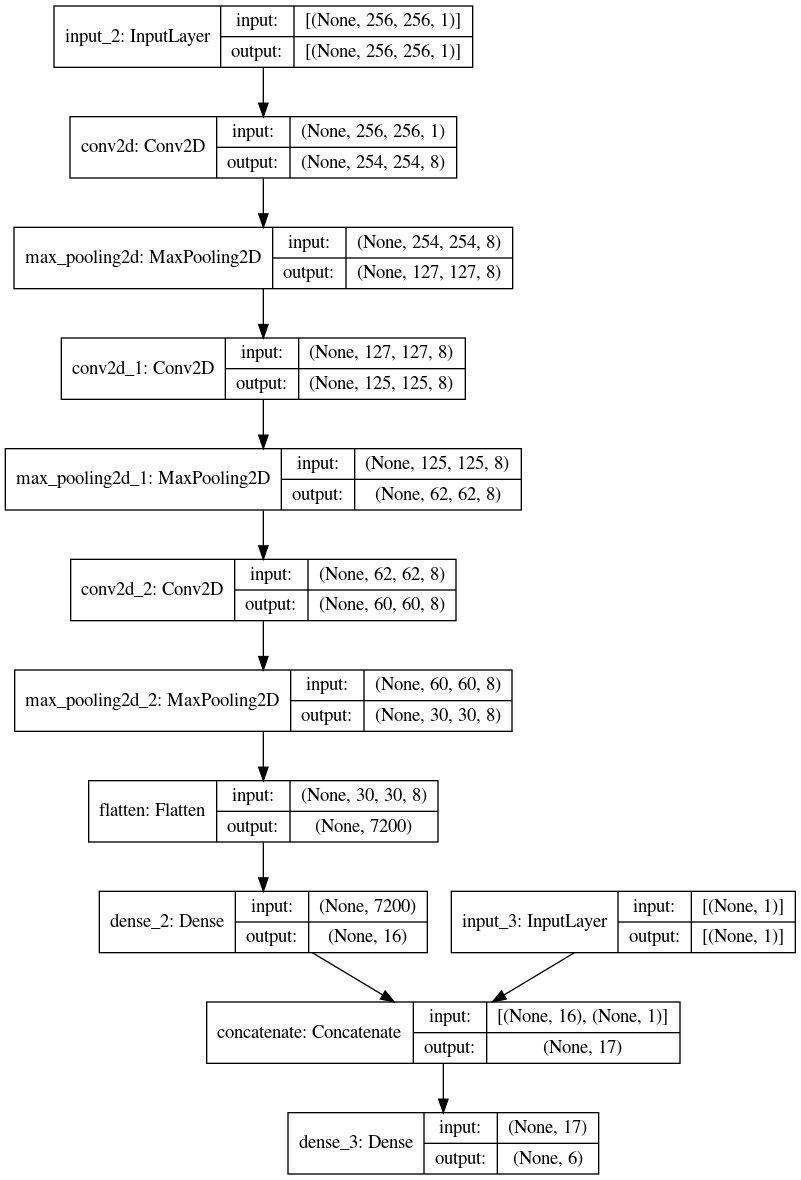

In [56]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [57]:
def hsv_hist(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1], None, [256, 256], [0, 256, 0, 256])
    #print(hist)8
    return hist

In [59]:
label_dict = {"out_of_focus":1, "HE":2, "negative":3, "strong_positive":4, "dim_positive":5, "no_tissue": 0}
x_train,y_train = [], []
x_test,y_test = [], []
for indx in df.index:
    print(indx, end="\r")
    #if indx > 100:
    #    break
    if df["gt_label"][indx] == "necrotic":
        continue
    else:
        img_path = "/home/jupyter/" + df["path"][indx][22:]
        im = cv2.imread(img_path)
        hist = hsv_hist(im)
        #print(im.shape)
        #break
        example = [np.expand_dims(hist, axis=-1), [var_of_laplacian(im)]]
        label = label_dict[df["gt_label"][indx]]
        
        if df["split"][indx] == "TEST" or df["split"][indx] == "VALIDATION":
            x_test.append(example)
            y_test.append(label)
        else:
            x_train.append(example)
            y_train.append(label)

In [60]:
def generator_train():
    X = x_train
    Y= y_train
    for i,x in enumerate(X):
        yield (x[0], x[1]),Y[i]

In [61]:
def generator_test():
    X = x_test
    Y= y_test
    for i,x in enumerate(X):
        yield (x[0], x[1]),Y[i]

In [62]:
train = tf.data.Dataset.from_generator(generator_train ,
                                        output_types= ((tf.uint8, tf.float32), tf.uint8),
                                        output_shapes= (([256,256,1], [1]),[]))
train = train.batch(16)

val = tf.data.Dataset.from_generator(generator_test ,
                                        output_types= ((tf.uint8, tf.float32), tf.uint8),
                                        output_shapes= (([256,256,1], [1]),[]))
val = val.batch(16)

In [69]:
len(x_train)

4262

In [63]:
for x in train.take(1):
    print(x[0][0].shape)

(16, 256, 256, 1)


In [64]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [65]:
cnn_model.fit(train, validation_data=val, epochs=10)

Epoch 1/10
267/267 [==============================] - 53s 199ms/step - loss: 88.8698 - accuracy: 0.5788 - val_loss: 18.2776 - val_accuracy: 0.8462
Epoch 2/10
267/267 [==============================] - 53s 200ms/step - loss: 13.4347 - accuracy: 0.8534 - val_loss: 11.1904 - val_accuracy: 0.8733
Epoch 3/10
267/267 [==============================] - 53s 198ms/step - loss: 9.1005 - accuracy: 0.8770 - val_loss: 10.3133 - val_accuracy: 0.8770
Epoch 4/10
267/267 [==============================] - 54s 201ms/step - loss: 6.5671 - accuracy: 0.8916 - val_loss: 7.7294 - val_accuracy: 0.8816
Epoch 5/10
267/267 [==============================] - 55s 204ms/step - loss: 5.4694 - accuracy: 0.8979 - val_loss: 8.7440 - val_accuracy: 0.8882
Epoch 6/10
267/267 [==============================] - 54s 201ms/step - loss: 3.8936 - accuracy: 0.9140 - val_loss: 6.6146 - val_accuracy: 0.8891
Epoch 7/10
267/267 [==============================] - 53s 200ms/step - loss: 3.0461 - accuracy: 0.9183 - val_loss: 5.4474 - v

In [70]:
total = 0
tp, fn, fp, tn = 0, 0, 0, 0
for indx in df.index:
    if df["gt_label"][indx] == "no_tissue":
        continue
    else:
        example = [df["laplacian_var"][indx], df["purple_cover"][indx], df["brown_cover"][indx]]
        label = cnn_model.predict([example])
        label = np.argmax(label, axis=-1)[0]
        if df["gt_label"][indx] == "out_of_focus":
            total += 1
            if label == 1:
                tp += 1
            else:
                fn += 1
        else:
            if label == 1:
                fp += 1
            else:
                tn += 1

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:207 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer model expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 3) dtype=float32>]
